In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/potato1/QVI_purchase_behaviour.csv
/kaggle/input/potato1/QVI_transaction_data.csv
/kaggle/input/potato1/QVI_transaction_data.xlsx


In [3]:
# Load and perform initial cleaning of the data

# Load transaction data
transaction_data = pd.read_excel('../input/potato1/QVI_transaction_data.xlsx')

In [4]:
 # Load customer behavior data
customer_data = pd.read_csv('../input/potato1/QVI_purchase_behaviour.csv')

In [5]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [6]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [7]:
# Convert Excel numeric date to datetime
transaction_data['DATE'] = pd.to_datetime(
    transaction_data['DATE'], unit='D', origin='1899-12-30')

In [8]:
#%% Clean product names
# Remove salsa products
transaction_data = transaction_data[
    ~transaction_data['PROD_NAME'].str.lower().str.contains('salsa')]


In [9]:
#%% Handle outliers
# Check quantity outliers
print("\nProduct quantity summary:")
print(transaction_data['PROD_QTY'].describe())


Product quantity summary:
count    246742.000000
mean          1.908062
std           0.659831
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         200.000000
Name: PROD_QTY, dtype: float64


In [10]:
# Find transactions with 200 packets
outlier_transactions = transaction_data[transaction_data['PROD_QTY'] == 200]
print("\nOutlier transactions:")
print(outlier_transactions)


Outlier transactions:
            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 2018-08-19        226          226000  226201         4   
69763 2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200      650.0  
69763  Dorito Corn Chp     Supreme 380g       200      650.0  


In [11]:
# Remove outlier customer
loyalty_outlier = outlier_transactions['LYLTY_CARD_NBR'].unique()
transaction_data = transaction_data[
    ~transaction_data['LYLTY_CARD_NBR'].isin(loyalty_outlier)]

In [12]:
#%% Feature engineering
# Extract pack size
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract('(\d+)').astype(float)


In [13]:
# Create brand name (first word in product name)
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0]

In [14]:
# Clean brand names
transaction_data['BRAND'] = transaction_data['BRAND'].replace({
    'Red': 'RRD',
    'RRD': 'Red Rock Deli',
    'Snbts': 'Sunbites',
    'GrnWves': 'Grain Waves',
    'Infzns': 'Infuzions'
})


In [15]:
#%% Merge customer data
merged_data = pd.merge(transaction_data, customer_data, 
                      on='LYLTY_CARD_NBR', how='left')

In [16]:
# Check for missing customers
print("\nMissing customer data count:", merged_data['LIFESTAGE'].isna().sum())



Missing customer data count: 0


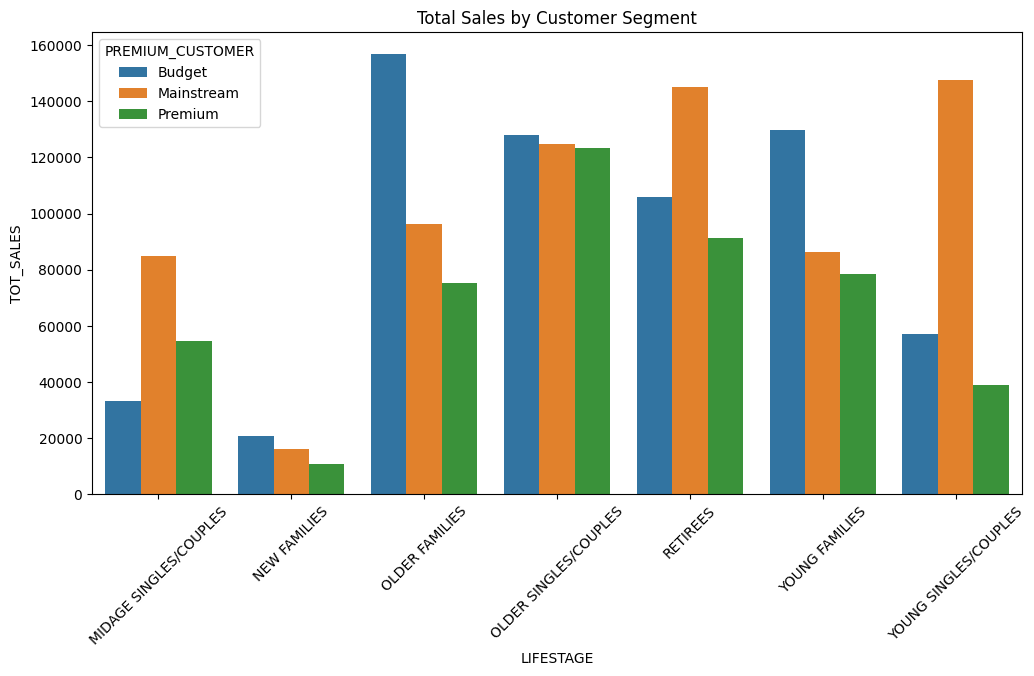

In [17]:
#%% Customer segment analysis
# Total sales by segment
total_sales = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()


plt.figure(figsize=(12,6))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', data=total_sales)
plt.title('Total Sales by Customer Segment')
plt.xticks(rotation=45)
plt.show()


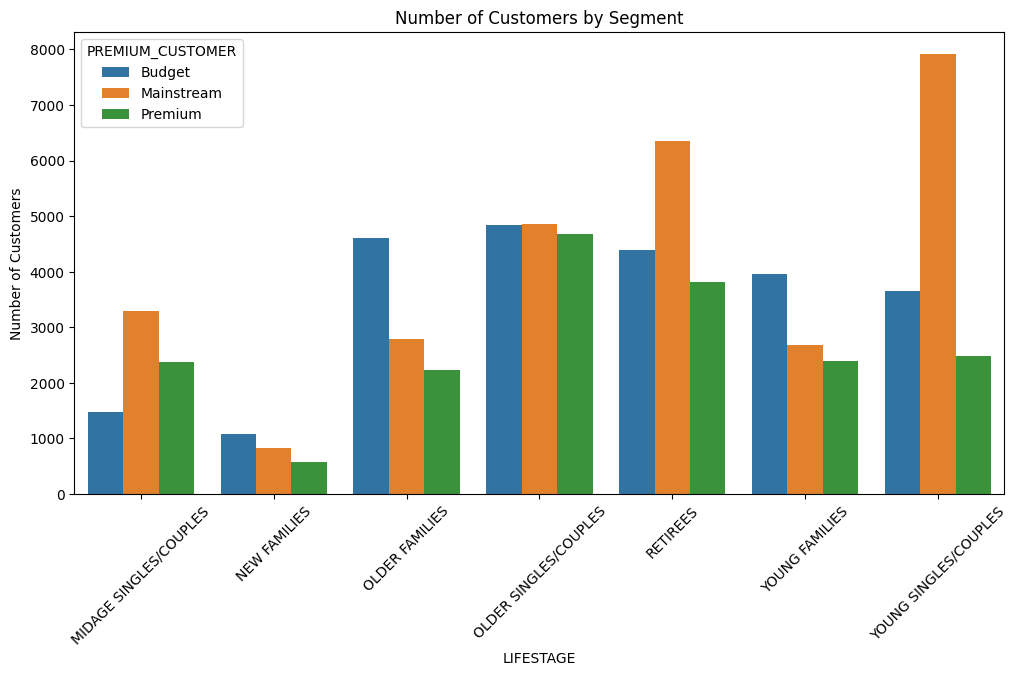

In [18]:
# Number of customers by segment
customer_count = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='LIFESTAGE', y='LYLTY_CARD_NBR', hue='PREMIUM_CUSTOMER', data=customer_count)
plt.title('Number of Customers by Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

In [19]:
#%% Price analysis
mainstream = merged_data[
    (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream') &
    (merged_data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']))
]

premium_budget = merged_data[
    (merged_data['PREMIUM_CUSTOMER'].isin(['Premium', 'Budget'])) &
    (merged_data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']))
]

t_stat, p_value = stats.ttest_ind(mainstream['TOT_SALES'], premium_budget['TOT_SALES'])
print(f"\nT-test p-value: {p_value:.4f}")



T-test p-value: 0.0000


In [20]:
#%% Deep dive into Mainstream young singles/couples
target_segment = merged_data[
    (merged_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (merged_data['PREMIUM_CUSTOMER'] == 'Mainstream')
]

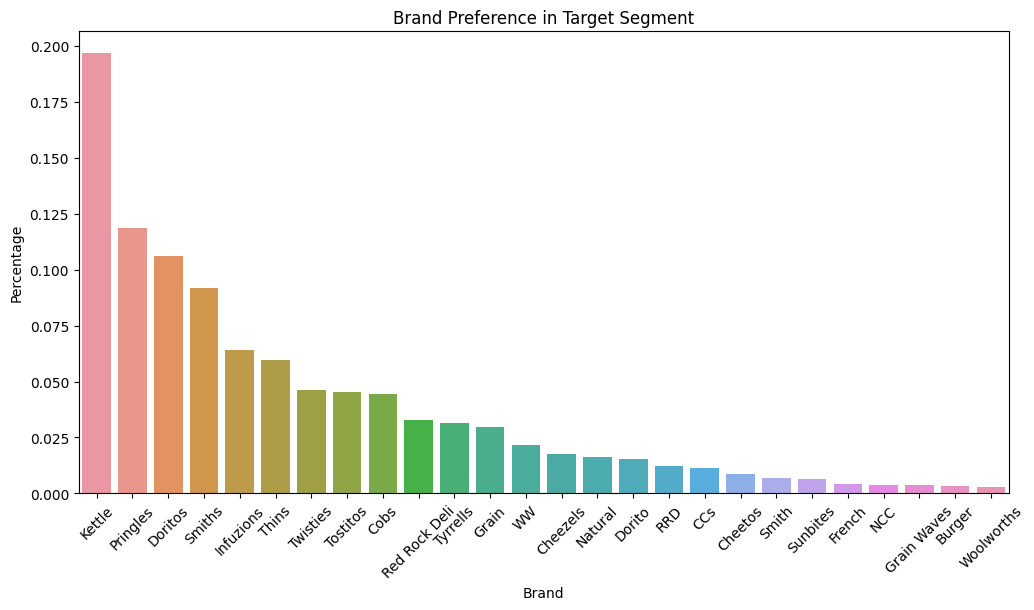

In [21]:
# Brand preference
brand_preference = target_segment['BRAND'].value_counts(normalize=True).reset_index()
brand_preference.columns = ['Brand', 'Percentage']

plt.figure(figsize=(12,6))
sns.barplot(x='Brand', y='Percentage', data=brand_preference)
plt.title('Brand Preference in Target Segment')
plt.xticks(rotation=45)
plt.show()